# Flight Analysis

In this notebook, we applied data analysis and machine learning techniques to real flight data.
Our objective was to explore, clean, and visualize the dataset to uncover meaningful insights about flight delays, airport performance, and overall flight patterns.
We then developed and evaluated predictive models to estimate the likelihood of flight delays with the goal of improving operational understanding and decision-making.

### Possible questions:

`1.` What drives flight delays? (by airline, origin, destination, time of day)

`2.` Which routes are most/least reliable?

`3.` Seasonal or daily patterns in cancellations or delays

`4.` Are there clusters of similar airports/routes?

`5.` Predict whether a flight will be delayed


### Sumary

I. [Exploratory Data Analysis](#Exploratory-Data-Analysis)

In [6]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from modules.flight_preprocessor import FlightPreprocessor

In [38]:
df_flights = pd.read_csv("./data/flights.csv", low_memory=False)

# Set the columns to lower case
df_flights.columns = df_flights.columns.str.lower()
df_flights = df_flights.fillna(0)

In [39]:
df_flights.head()

,year,month,day,day_of_week,airline,flight_number,tail_number,origin_airport,destination_airport,scheduled_departure,...,arrival_time,arrival_delay,diverted,cancelled,cancellation_reason,air_system_delay,security_delay,airline_delay,late_aircraft_delay,weather_delay
0,2015,1,1,4,AS,98,N407AS,ANC,SEA,5,...,408.0,-22.0,0,0,0,0.0,0.0,0.0,0.0,0.0
1,2015,1,1,4,AA,2336,N3KUAA,LAX,PBI,10,...,741.0,-9.0,0,0,0,0.0,0.0,0.0,0.0,0.0
2,2015,1,1,4,US,840,N171US,SFO,CLT,20,...,811.0,5.0,0,0,0,0.0,0.0,0.0,0.0,0.0
3,2015,1,1,4,AA,258,N3HYAA,LAX,MIA,20,...,756.0,-9.0,0,0,0,0.0,0.0,0.0,0.0,0.0
4,2015,1,1,4,AS,135,N527AS,SEA,ANC,25,...,259.0,-21.0,0,0,0,0.0,0.0,0.0,0.0,0.0


### <a class="anchor" id="Exploratory-Data-Analysis">Part I : Exploratory Data Analysis</a>

`1.` What is the distribution and correlation of the main flight variables, such as departure delay, arrival delay, distance, and airtime?

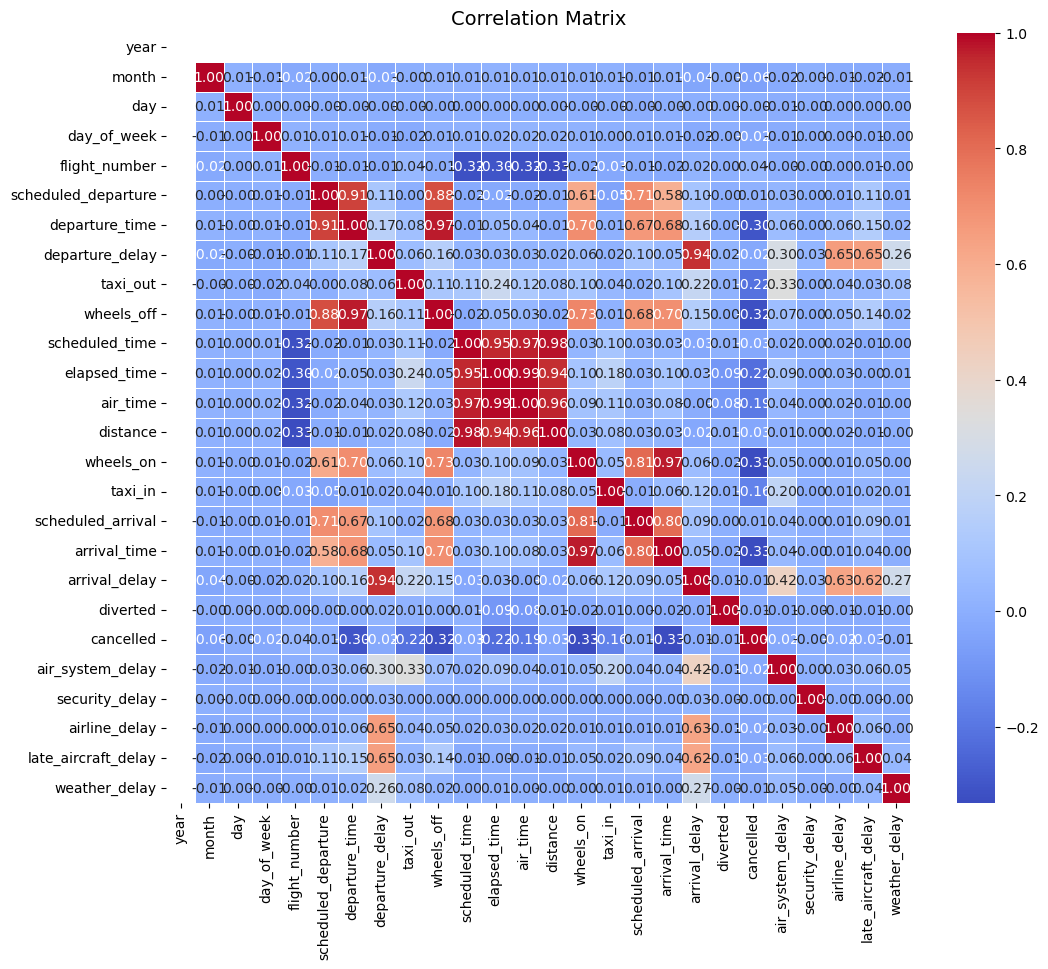

In [40]:
corr = df_flights.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix", fontsize=14)
plt.show()

### Understanding Variable Correlation

#### Variables with Strong Correlation

Several variables exhibit strong correlations, indicating that they carry redundant or overlapping information.
In other words, they describe similar aspects of the same underlying phenomenon.
To address this, it may be useful to apply dimensionality reduction, either by removing duplicate variables or by combining multiple attributes into a single representative feature.
Some examples include:

- arrival_delay ↔ departure_delay
- schedule_time ↔ elapsed_time ↔ air_time ↔ distance
- arrival_time ↔ wheels_on ↔ scheduled_arrival ↔ wheels_off
- late_aircraft_delay ↔ arrival_delay ↔ airline_delay

Reducing redundancy helps simplify the dataset, improve model interpretability, and prevent overfitting in predictive modeling.

#### Variables with Weak or No Correlation

On the other hand, variables with weak or no correlation show little to no direct relationship between each other.
These features may not significantly contribute to predictive models and could be candidates for removal after further analysis. Examples include:

- flight_number ↔ distance
- flight_number ↔ air_time
- flight_number ↔ elapsed_time
- flight_number ↔ schedule_time

Some relationships also appear weak because the events do not occur together logically — for instance, a canceled flight will not have data for variables related to physical movement:

- cancelled ↔ departure_time
- cancelled ↔ taxi_out
- cancelled ↔ wheels_off
- cancelled ↔ wheels_on
- cancelled ↔ arrival_time

In [42]:
# variables_to_remove = ['flight_number', 'wheels_on', 'wheels_off', 'cancellation_reason']
# df_flights = df_flights.drop(columns=variables_to_remove)

`2.` Which airports and airlines have the highest frequency of delays?


`3.` Are there specific times of day, days of the week, or months associated with more delays?

In [16]:
df_schedules = df_flights[['scheduled_departure', 'departure_time', 'departure_delay', 'scheduled_arrival', 'arrival_time', 'arrival_delay']]

processor = FlightPreprocessor()
df_schedules = processor.preprocess(df_schedules)

In [17]:
df_schedules.head()

,scheduled_departure,departure_time,departure_delay,scheduled_arrival,arrival_time,arrival_delay
0,2024-01-01 00:05:00,2024-01-01 23:54:00,-11.0,2024-01-02 04:30:00,2024-01-02 04:08:00,-22.0
1,2024-01-01 00:10:00,2024-01-01 00:02:00,-8.0,2024-01-01 07:50:00,2024-01-01 07:41:00,-9.0
2,2024-01-01 00:20:00,2024-01-01 00:18:00,-2.0,2024-01-01 08:06:00,2024-01-01 08:11:00,5.0
3,2024-01-01 00:20:00,2024-01-01 00:15:00,-5.0,2024-01-01 08:05:00,2024-01-01 07:56:00,-9.0
4,2024-01-01 00:25:00,2024-01-01 00:24:00,-1.0,2024-01-01 03:20:00,2024-01-01 02:59:00,-21.0


In [18]:
# Compute delay metrics
df_schedules['dep_delay_min'] = (df_schedules['departure_time'] - df_schedules['scheduled_departure']).dt.total_seconds() / 60
df_schedules['arr_delay_min'] = (df_schedules['arrival_time'] - df_schedules['scheduled_arrival']).dt.total_seconds() / 60

# Additional derived features
df_schedules['day_of_week'] = df_schedules['scheduled_departure'].dt.day_name()
df_schedules['hour'] = df_schedules['scheduled_departure'].dt.hour
df_schedules['is_delayed'] = df_schedules['dep_delay_min'] > 15


In [8]:
df_schedules.head()

,scheduled_departure,departure_time,departure_delay,scheduled_arrival,arrival_time,arrival_delay,dep_delay_min,arr_delay_min,day_of_week,hour,is_delayed
0,2024-01-01 00:05:00,2024-01-01 23:54:00,-11.0,2024-01-02 04:30:00,2024-01-02 04:08:00,-22.0,1429.0,-22.0,Monday,0,True
1,2024-01-01 00:10:00,2024-01-01 00:02:00,-8.0,2024-01-01 07:50:00,2024-01-01 07:41:00,-9.0,-8.0,-9.0,Monday,0,False
2,2024-01-01 00:20:00,2024-01-01 00:18:00,-2.0,2024-01-01 08:06:00,2024-01-01 08:11:00,5.0,-2.0,5.0,Monday,0,False
3,2024-01-01 00:20:00,2024-01-01 00:15:00,-5.0,2024-01-01 08:05:00,2024-01-01 07:56:00,-9.0,-5.0,-9.0,Monday,0,False
4,2024-01-01 00:25:00,2024-01-01 00:24:00,-1.0,2024-01-01 03:20:00,2024-01-01 02:59:00,-21.0,-1.0,-21.0,Monday,0,False


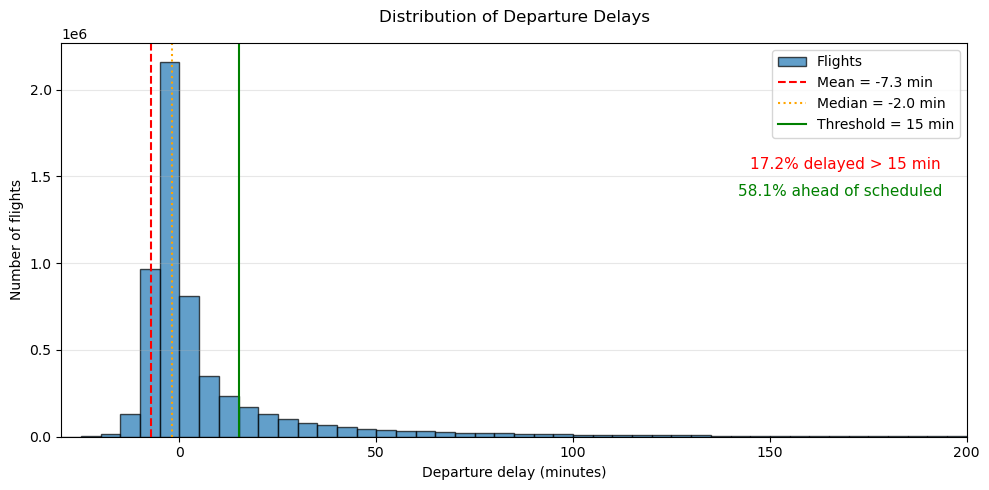

In [36]:
delays = df_schedules['dep_delay_min'].dropna()
threshold = 15  # delay threshold in minutes

plt.figure(figsize=(10, 5))
plt.hist(
    delays,
    bins=np.arange(-30, 301, 5),
    color="#1f77b4",
    alpha=0.7,
    edgecolor="black",
    label="Flights"
)

# Mean and median
mean_delay = delays.mean()
median_delay = delays.median()
plt.axvline(mean_delay, color='red', linestyle='--', linewidth=1.5, label=f"Mean = {mean_delay:.1f} min")
plt.axvline(median_delay, color='orange', linestyle=':', linewidth=1.5, label=f"Median = {median_delay:.1f} min")

# Delay threshold
plt.axvline(threshold, color='green', linestyle='-', linewidth=1.5, label=f"Threshold = {threshold} min")

# Label, title, etc.
plt.xlim(-30, 200)
plt.xlabel('Departure delay (minutes)')
plt.ylabel('Number of flights')
plt.title('Distribution of Departure Delays', pad=15)

# % of delayed flights
delayed_pct = (delays > threshold).mean() * 100

plt.text(
    145, plt.ylim()[1] * 0.68,
    f"{delayed_pct:.1f}% delayed > {threshold} min",
    color="red", fontsize=11
)

# % of ahead of scheduled flights
ahead_scheduled_pct = (delays < 0).mean() * 100
plt.text(
    142, plt.ylim()[1] * 0.61,
    f"{ahead_scheduled_pct:.1f}% ahead of scheduled",
    color="green", fontsize=11
)

plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

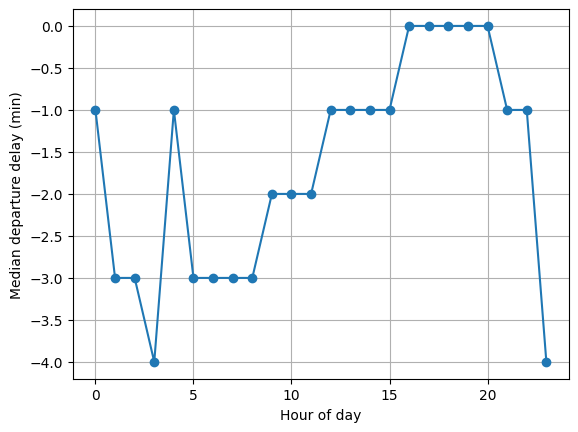

In [42]:
hourly = df_schedules.groupby('hour')['dep_delay_min'].median().reset_index()
plt.plot(hourly['hour'], hourly['dep_delay_min'], marker='o')
plt.xlabel('Hour of day')
plt.ylabel('Median departure delay (min)')
plt.grid(True)
plt.show()